In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("../Sonipat_AQI_Weather.csv")

# Drop redundant columns
df.drop(df.columns[[0, 1, 2]], axis = 1, inplace = True) 

# Inspecting shape of the data
print("The dataset has {} rows and {} columns.".format(df.shape[0], df.shape[1]))

# Inspecting first five rows
df.head()

The dataset has 365 rows and 15 columns.


,PM 2.5,PM 10,NO2,NH3,SO2,CO,O3,Min_Temp,Max_Temp,Precip_Intensity,Pressure,Humidity,Wind_Speed,Wind_Bearing,Cloud_Cover
0,332.0,214.0,40.0,17.0,21.0,57.0,2.0,6.38,21.43,0.0,1020.3,0.56,3.64,316,0.00
1,413.0,365.0,63.0,18.0,34.0,94.0,17.0,9.07,23.17,0.0,1020.5,0.60,3.74,68,0.05
2,427.0,379.0,71.0,20.0,40.0,94.0,NaN,8.59,22.22,0.0,1021.1,0.65,6.18,299,0.00
3,370.0,254.0,40.0,19.0,19.0,62.0,NaN,7.79,20.61,0.0,1020.3,0.63,4.10,290,0.42
4,NaN,NaN,45.0,20.0,NaN,102.0,NaN,8.17,20.56,0.0,1019.3,0.66,7.26,110,0.08


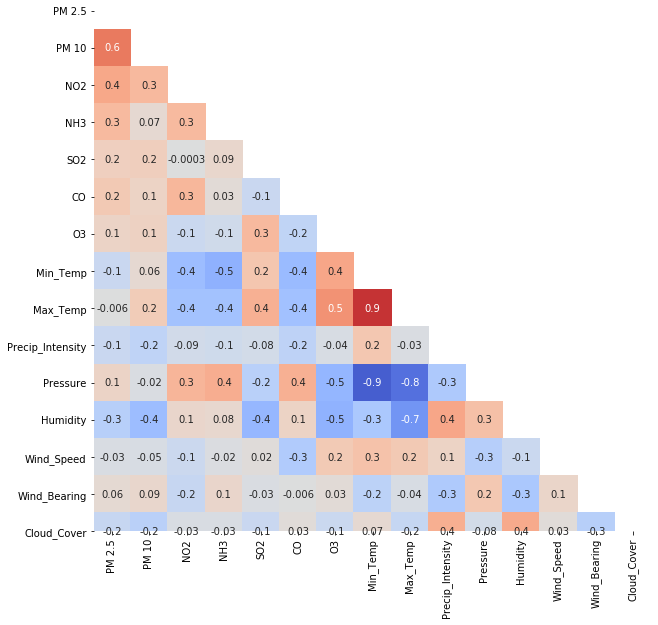

In [3]:
# Drawing a correlation plot
plt.figure(figsize=(10,10))

matrix = np.triu(df.corr())

correlation_plot = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, 
            center=0, cmap= 'coolwarm', square=True, fmt='.1g',
            mask=matrix, linecolor='black', cbar=False)

In [4]:
# Target Variable - `PM 2.5 has a very high correlation with PM10 and NO2, so we drop the columns.
_dfpm25 = df.drop(['PM 10', 'NO2'], axis = 1) 

# Keeping rows where we have a valid value of `PM 2.5` and other features
_dfpm25 = _dfpm25[_dfpm25['PM 2.5'].notna()]
_dfpm25.dropna(subset = _dfpm25.columns[1:], inplace=True)

# Drop columns with low standard deviation.
_dfpm25 = _dfpm25.drop(_dfpm25.std()[_dfpm25.std() < 1.0].index.values, axis=1)

# Inspecting dataframe shape
print(_dfpm25.shape)

(298, 10)


### Multiple Linear Regression

In [5]:
# Selecting target variable and features
X = _dfpm25.loc[:, _dfpm25.columns != 'PM 2.5'].values
y = _dfpm25.iloc[:, 0].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
from sklearn import metrics

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)
print("R2 square score for Multiple Linear Regression is: {0:.4f}".format(np.sqrt(metrics.r2_score(y_test, y_pred))))

R2 square score for Multiple Linear Regression is: 0.3912


### Support Vector Regression

In [6]:
# Selecting target variable and features
X = _dfpm25.loc[:, _dfpm25.columns != 'PM 2.5'].values
y = _dfpm25.iloc[:, 0].values

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1))

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting SVR to the training set
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf', gamma='auto')
regressor.fit(X_train, np.ravel(y_train))

# Predicting the Test set results
y_pred = regressor.predict(X_test)
print("R2 square score for Support Vector Regression is: {0:.4f}".format(np.sqrt(metrics.r2_score(y_test, y_pred))))

R2 square score for Support Vector Regression is: 0.6765


### Random Forest Regression

In [27]:
# Selecting target variable and features
X = _dfpm25.loc[:, _dfpm25.columns != 'PM 2.5'].values
y = _dfpm25.iloc[:, 0].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Grid Search CV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

n_estimators = np.arange(10, 500, 20)
max_features = ['auto', 'sqrt', 'log2']

grid = dict(n_estimators = n_estimators,
            max_features = max_features)

searcher = GridSearchCV(regressor, 
                        param_grid = grid,
                        cv = 5, n_jobs=-1, verbose=1)

# Fitting Random Forest Regression to the training set
searcher.fit(X_train, np.ravel(y_train))

# Predicting the Test set results
y_pred = searcher.predict(X_test)
print(searcher.best_params_)
print("R2 square score for Support Vector Regression is: {0:.4f}".format(np.sqrt(metrics.r2_score(y_test, y_pred))))

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  1.2min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 'sqrt', 'n_estimators': 410}
R2 square score for Support Vector Regression is: 0.6696
